# Vehicle Detection

## 1. Load libraries

In [6]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.misc import imread
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetections2 import DecodeDetections2
from keras_layers.keras_layer_L2Normalization import L2Normalization
from ssd_box_utils.ssd_box_encode_decode_utils import decode_y, decode_y2
from data_generator.ssd_batch_generator import BatchGenerator
import os
import cv2


## 2. Download and save SSD weights, pretrained on MS COCO

In [7]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [8]:
file_id = '1vmEF7FUsWfHquXyCqO17UaXOPpRbwsdj'
weights_source_path = './VGG_coco_SSD_300x300_iter_400000.h5'
download_file_from_google_drive(file_id, weights_source_path)

In [9]:
weights_destination_path = './VGG_coco_SSD_300x300_iter_400000_subsampled_5_classes.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'./VGG_coco_SSD_300x300_iter_400000_subsampled_5_classes.h5'

In [10]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

## 3. Sub-sample the classifier weights


In [11]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

In [12]:
classes = ['background', 'car', 'truck', 'bicyclist', 'motorcycle', 'bus']

In [13]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for MS COCO's 80 classes, this must be 80 + 1 = 81.
n_classes_source = 81
# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.
classes_of_interest = [0, 3, 8, 2, 4, 6]
# classes_of_interest = 9 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)

    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

In [14]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 24)
bias:	 (24,)


## 4. Define SSD parameters for Keras model

In [16]:
img_height = 360 # Height of the input images
img_width = 640 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = True # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.
# TODO: Set the number of classes.
n_classes = 5 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets.
# scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets.
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids', 'corners', or 'minmax' format, see documentation
normalize_coords = True

## 5. Build the Keras model

In [17]:
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='inference',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                limit_boxes=limit_boxes,
                variances=variances,
                coords=coords,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Load the sub-sampled weights into the model.

# Load the weights that we've just created via sub-sampling.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
dim is deprecated, use axis instead
Model built.
Weights file loaded: ./VGG_coco_SSD_300x300_iter_400000_subsampled_5_classes.h5


In [18]:
# Function definition to apply vehicle detection on image
def detect_vehicles(input_images):
    y_pred = model.predict(input_images)

    confidence_threshold = 0.6    
    # Get detections with confidence higher than 0.6.
    y_pred = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
   
    return y_pred

In [19]:
def load_preprocess_image(image_path):
    input_images = [] # Store resized versions of the images here.
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    input_images.append(img)
    input_images = np.array(input_images)    
    
    return input_images

def preprocess_image(img):
    
    input_images = []    
    pil_im = Image.fromarray(img)
    pil_im.thumbnail((img_width, img_height))
    input_images.append(image.img_to_array(pil_im))
    input_images = np.array(input_images)    
    
    return input_images

In [20]:
colors = plt.cm.hsv(np.linspace(0, 1, 6)).tolist()

In [28]:
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.figure import Figure

def process_data(data, orig_image, show=False, out_path=None):
    y_pred = detect_vehicles(data)
    # Visualize the predictions.
    fig = plt.Figure()
    fig.figimage(orig_image, resize=True)
    current_axis = fig.add_axes([0,0,1,1])
    current_axis.axis('off') 
    current_axis.imshow(orig_image, aspect='equal')    
    
    # Draw the predicted boxes in blue
    for box in y_pred[0]:
        class_id = box[0]
        confidence = box[1]        
        xmin = box[-4] * orig_image.shape[1] / img_width
        ymin = box[-3] * orig_image.shape[0] / img_height
        xmax = box[-2] * orig_image.shape[1] / img_width
        ymax = box[-1] * orig_image.shape[0] / img_height
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(class_id)], confidence)
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})    
        
    result = mplfig_to_npimage(fig)
    if show == True:
        plt.imshow(result)
        plt.show()

    if out_path is not None:
        cv2.imwrite(out_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result

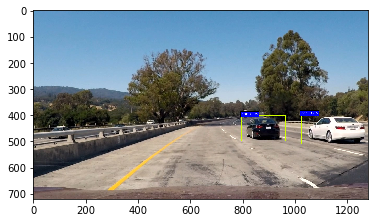

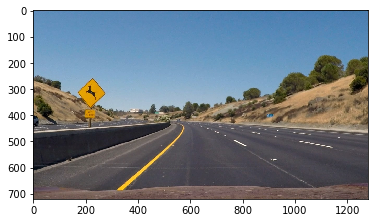

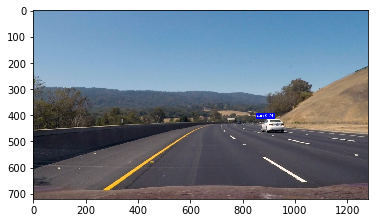

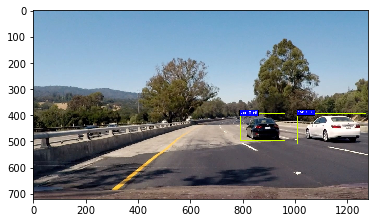

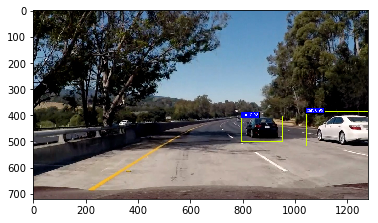

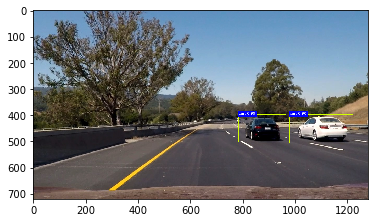

In [29]:
for test_image_file in os.listdir('./test_images/'):
    img_path = './test_images/'+test_image_file
    orig_image = imread(img_path)
    data = load_preprocess_image(img_path)
    
    out_path = './output_images/'+test_image_file
    process_data(data, orig_image, True, out_path)
        
    

In [18]:
from moviepy.editor import VideoFileClip
from PIL import Image

def process_frame(img):
    data = preprocess_image(img)    
    result = process_data(data, img, (16, 9))   
    
    return result        
       
def process_video(in_video = 'project_video.mp4'):  
    
    white_output = 'result_' + in_video
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(in_video)
    white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)
    white_clip.reader.close()
    white_clip.audio.reader.close_proc() 

In [19]:
process_video()

[MoviePy] >>>> Building video result_project_video.mp4
[MoviePy] Writing video result_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:53<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_video.mp4 



In [20]:
process_video('test_video.mp4')

[MoviePy] >>>> Building video result_test_video.mp4
[MoviePy] Writing video result_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:18<00:00,  2.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_test_video.mp4 

